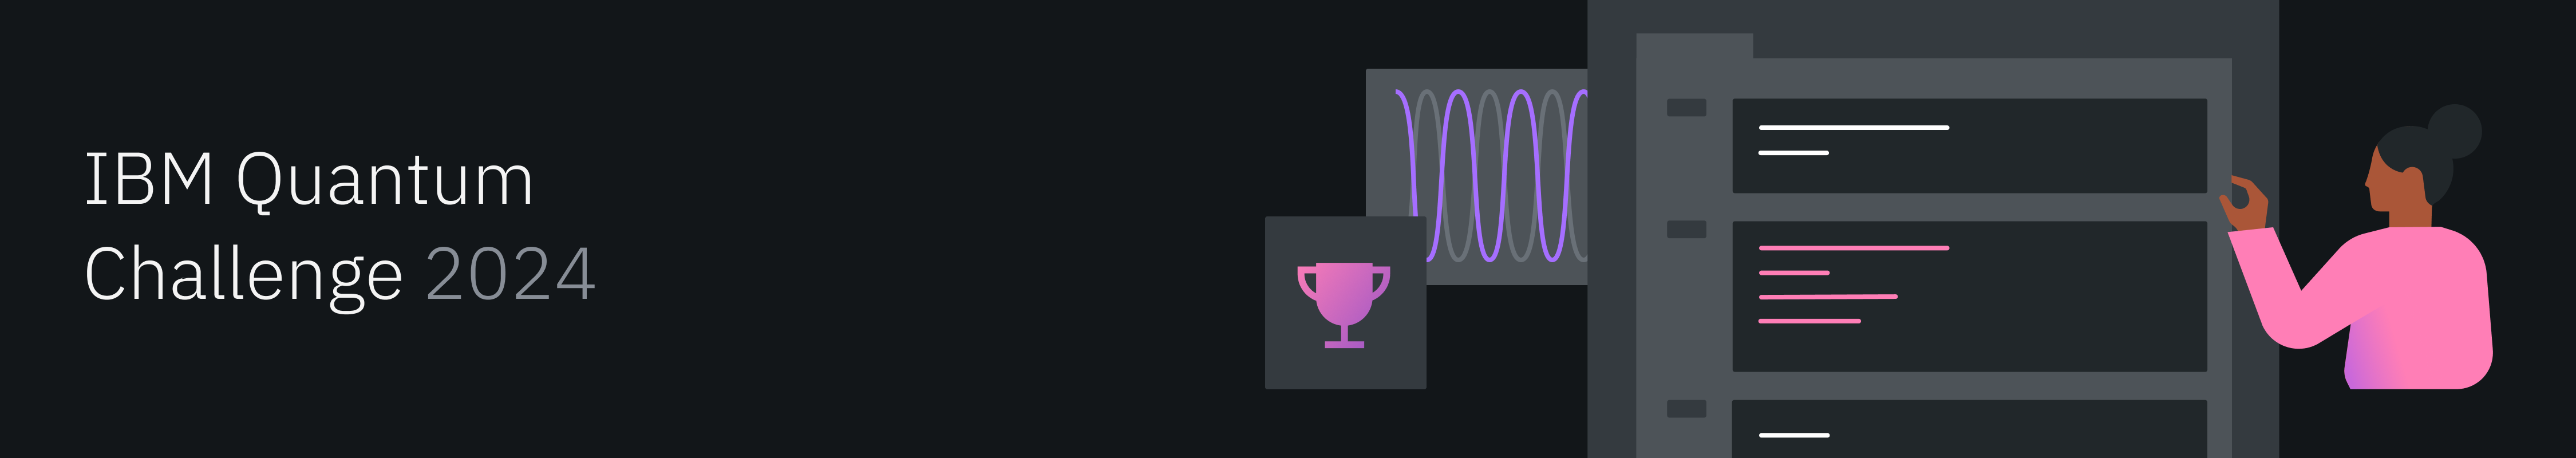

# Lab 5: Upcoming Features Challenge

# Table of Contents

* [Part 1: Circuit Knitting Toolbox](#Part-1:-Circuit-Knitting-Toolbox)
    * [Exercise 1](#exercise1)
* [Part 2: Custom Fake Backends](#Part-2:-Custom-Fake-Backends)
    * [Exercise 2](#exercise2)
    * [Exercise 3](#exercise3)
* [Part 3: Qiskit Code Assistant](#Part-3:-Qiskit-Code-Assistant)

# Imports

In [2]:
#! pip install circuit-knitting-toolbox

In [1]:
# Import all in one cell

# Import common packages first
import numpy as np

# Import qiskit classes
from qiskit import QuantumCircuit, ClassicalRegister, QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.result import marginal_counts
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_gate_map
from qiskit.quantum_info import SparsePauliOp

# Import qiskit ecosystems
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_aer import AerSimulator
from circuit_knitting.cutting import cut_gates
from circuit_knitting.cutting import generate_cutting_experiments

# Imports for the fakebackend
import math
import numpy as np
import rustworkx as rx
from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate, ECRGate
from qiskit.circuit import Measure, Delay, Parameter, IfElseOp, Reset
import os
from qiskit.visualization import plot_gate_map, plot_circuit_layout

/Users/kifumi/local/qiskit_env/qiskit_102_0503/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# For Testing purposes. Will remove for the final version

# This is required during testing phase. If you see the following error message:
# Failed: {'errors': [{'message': 'The challenge is not active', 'extensions': {'code': 'INVALID_QUERY'}}]}
# Restart the kernel and run this cell
%set_env QC_GRADE_ONLY=true

# If you see the following error message:
# Failed: Unable to access service (Forbidden)
# Uncomment the line below and copy and past your IBM Quantum token. See lab 0 for more detailed instructions
# %set_env QXToken=#your_token_here

# Part 1: Circuit Knitting Toolbox

Circuit cutting is a technique to increase the size of circuits we can run on quantum hardware at the cost of an additional sampling overhead. A larger quantum circuit can be decomposed by cutting its gates and/or wires, resulting in smaller circuits which can be executed within the constraints of available quantum hardware. The results of these smaller circuits are combined to reconstruct the outcome of the original problem. Circuit cutting can also be used to engineer gates between distant qubits which would otherwise require a large swap overhead.

### How do we overcome the limited connectivity?

Superconducting processors have limited connectivity. How do we overcome this? One of the solution is Circuit knitting with Local Operations and Classical Communication (LOCC).

### Theory

A quantum channel $\varepsilon$ can be decomposed into a linear combination of several channels $\varepsilon_i$ with coefficients $a_i$. Therefore, a virtual gate also is implemented by a sum over several circuits:

$$\varepsilon(\cdot) = \sum_i a_i \varepsilon(\cdot)$$
The $a_i$ do not form a valid probability decomposition since some $a_i<0$ cannot sample. We transform to a valid probability distribution via:

$$\gamma = \sum   |a_i| $$

So $\sum\frac{|a_i|}{\gamma}=1$. Therefore, $\frac{|a_i|}{\gamma}$ form a valid probability distribution:

$$\varepsilon(\rho) =\gamma \sum_i \frac{|a_i|}{\gamma} sign(a_i) \varepsilon_i(\cdot)$$
This allows us to cut gates.

### Single CNOT example

A CNOT gate can be deterministically implemented by consuming a Bell pair in a  teleportation circuit.

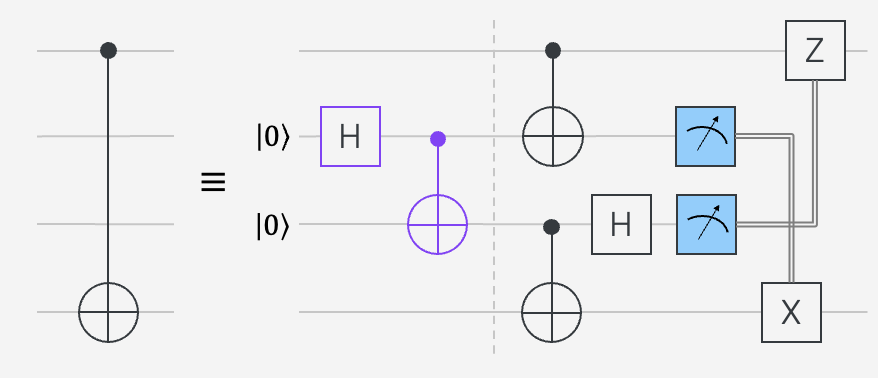

We will check it by applying H gate and CNOT gate between qubit_0 and qubit_3 so that we create the entanglement state of $|00\rangle$ and $|11\rangle$.

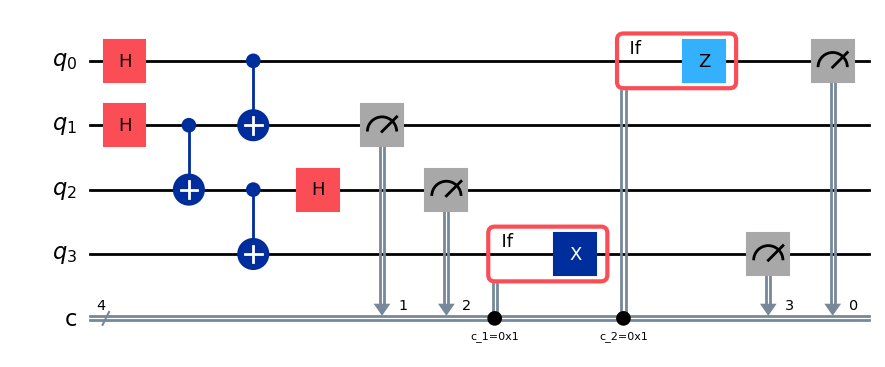

In [3]:
circuit = QuantumCircuit(4,4)

circuit.h(0)

circuit.h(1)
circuit.cx(1, 2)

circuit.cx(0 ,1)
circuit.cx(2, 3)

circuit.h(2)

circuit.measure(1, 1)
circuit.measure(2, 2)

with circuit.if_test((1, 1)):   
    circuit.x(3)
with circuit.if_test((2, 1)):
    circuit.z(0)               

circuit.measure(0,0)
circuit.measure(3,3)

circuit.draw("mpl")

We will run this circuit using AerSimulator. `marginal_counts` is marginalize counts from an experiment over some indices of interest.

{'1011': 127, '0000': 131, '1001': 142, '0010': 141, '0100': 135, '0110': 103, '1111': 125, '1101': 120}


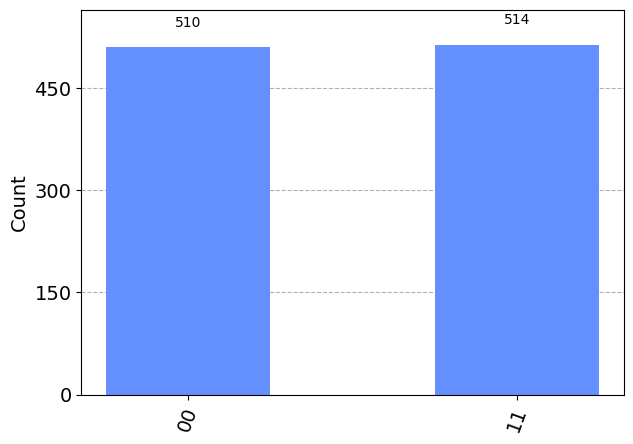

In [4]:
# Run the circuit on a simulator to get the results
backend = AerSimulator()

pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=0)
isa_qc = pm.run(circuit)

sampler = Sampler(backend)
job = sampler.run([isa_qc])

counts = job.result()[0].data.c.get_counts()
print(counts)

# Plot the marginal counts in a histogram
qubit0_3 = marginal_counts(counts, [0, 3])

plot_histogram(qubit0_3)

We confirmed that A CNOT gate can be deterministically implemented by consuming a Bell pair in a teleportation circuit!

However, it is not always possible to create the Bell pair with a CNOT gate. For example, if the qubits are far apart, we can perform circuit knitting by cutting the Bell pair and implementing it with a **Quasi-probability decomposition (QPD)**.

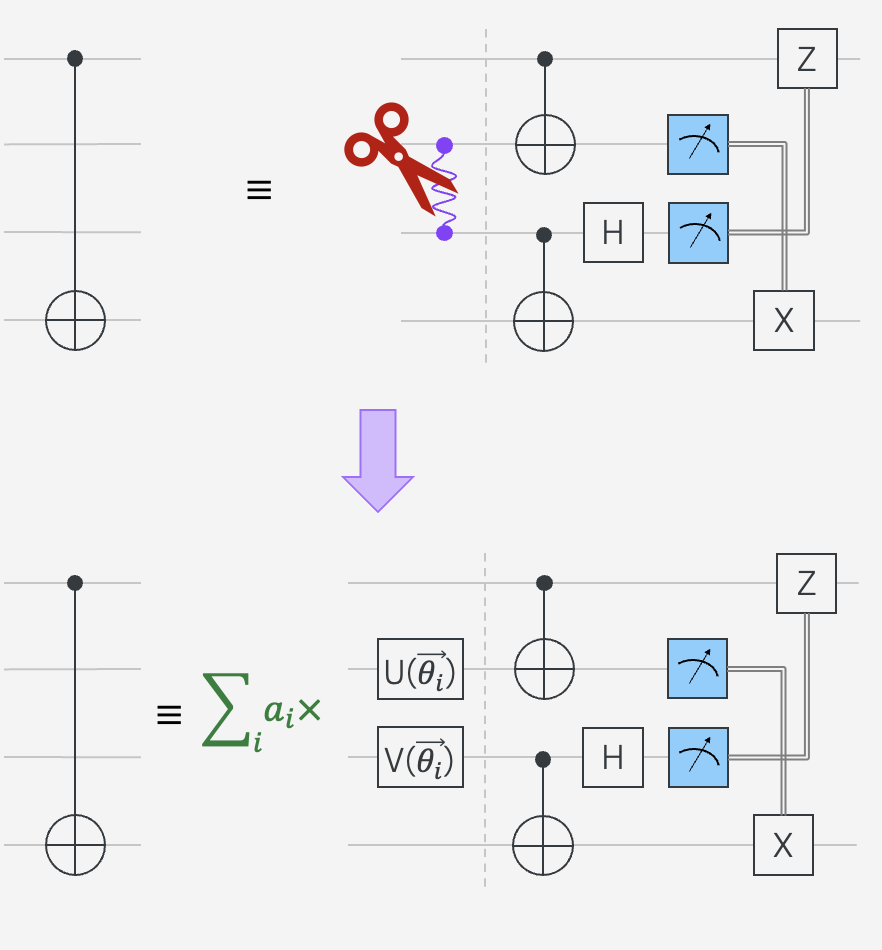


Now the top two and bottom two qubits are only connected via classical communication. The price we pay is to have to run several quantum circuits instead of one.  

### Example of a gate cutting in Bell circuit 
Now, let's think about only a Bell pair which are far apart.  We will investigate how we cut CNOT gate using Qiskit Circuit Knitting Toolbox in case where the two qubits are far apart.

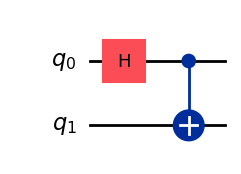

In [5]:
# create a bell pair
bell_state = QuantumCircuit(2)
bell_state.h(0)
bell_state.cx(0,1)
bell_state.draw("mpl")

We will use `FakeTorino` device, here. 

In [6]:
backend = FakeTorino()

In [7]:
### If you want to use the real device, you can try with below code.
# service = QiskitRuntimeService()
# backend = service.get_backend("ibm_kyoto")

Now, we choose a layout that requires many swaps to execute the gates between qubits 122 and 126 and another many swaps to return the qubits to their initial positions.

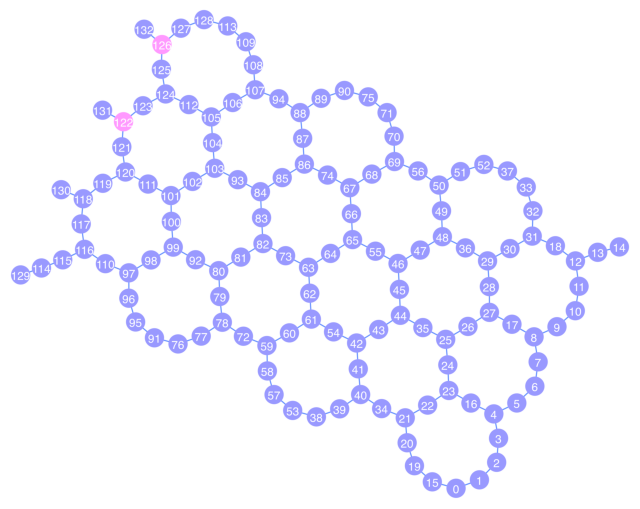

In [9]:
layout=[122, 126]
qubit_color = []
for i in range(133):
    if i in layout:
        qubit_color.append("#ff99ff")
    else:
        qubit_color.append("#9999ff")
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=80, font_size=40, figsize=(8,8))

We will transpile the bell pair circuit to get the Instruction Set Architecture (ISA) circuit which the device can understand and execute.

Transpiled circuit depth:  31


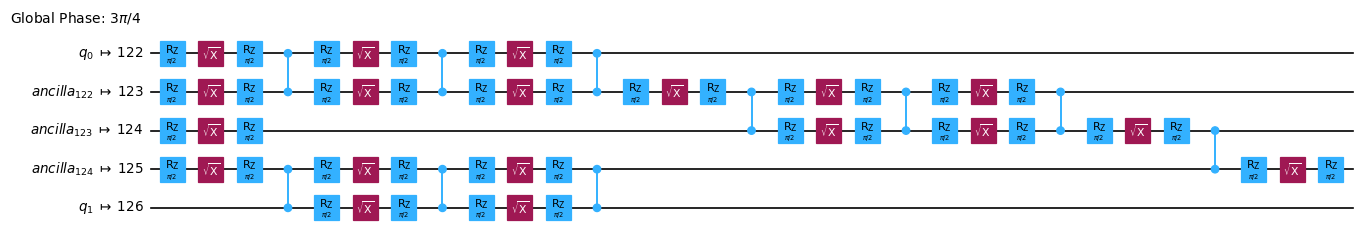

In [10]:
# transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout = layout, seed_transpiler=0)
isa_qc = pm.run(bell_state)

# original circuit depth
isa_qc_depth = isa_qc.depth()
print(f"Transpiled circuit depth: ", isa_qc_depth)
isa_qc.draw("mpl", idle_wires=False, style="iqp", scale=0.6, fold=-1)

We see that many ancilla qubits are used and the depth of the transpiled circuit is 31! This is the case if we don't use Qiskit Circuit Knitting Toolbox.

Now, we will introduce Circuit Knitting.    
We will replace the distant gates (gates connecting non-local qubits, 122 and 126) with `TwoQubitQPDGate`s by specifying their indices. `cut_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition. The ``QPDBasis`` object contains information about how to decompose the cut gates into single-qubit operations.

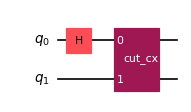

In [11]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(bell_state.data)
    if {bell_state.find_bit(q)[0] for q in instruction.qubits} == {0, 1}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(bell_state, cut_indices)

qpd_circuit.draw("mpl", style="iqp", scale=0.6)

In the next cell, `generate_cutting_experiments` accepts a circuit containing `TwoQubitQPDGate` instances and observables as a `PauliList`. 

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/circuit_cutting/explanation/index.rst).

In [12]:
observable = SparsePauliOp(["ZI"])

# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

Here is an example of an arbitrarily chosen subexperiment generated from the QPD circuit. Its depth has been reduced significantly from 31 to 7. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct an expectation value of the deeper circuit. For this circuit, we need 6 subexperiments to reconstruct it.

Original circuit depth after transpile:  31
QPD subexperiment depth after transpile:  7
Number of sub-experiments: 6


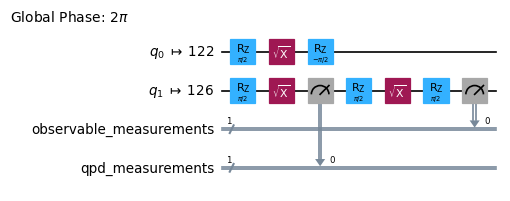

In [13]:
# Transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout = layout, seed_transpiler=0)
isa_qpd_circuit = pm.run(subexperiments[5])

# depth using circuit cutting
isa_qpd_depth = isa_qpd_circuit.depth()

print(f"Original circuit depth after transpile: ", isa_qc_depth)
print(f"QPD subexperiment depth after transpile: ", isa_qpd_depth)
print(f"Number of sub-experiments:", len(subexperiments))
isa_qpd_circuit.draw("mpl", scale=0.6, style="iqp", idle_wires=False, fold=-1)

The above circuit is 5th circuit in 6 subexperiments. Let's see the depth of all subexperiments.

In [14]:
x = np.array([c.depth() for c in pm.run(subexperiments)])
print(x)

[4 3 3 3 7 7]


In order to know the expectation value of the original circuit, a number of subexperiments must be executed. I this case, the six circuit need to be run and reconstructed using subobservables, and sampling coefficients. Therefore, using the circuit cutting, the depth of each circuit is decreased significantly, but a lot of circuits need to be executed.
For more information, please refer the tutorial ["Gate Cutting to Reduce Circuit Depth"](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/tutorials/02_gate_cutting_to_reduce_circuit_depth.html).

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 

Which gate connections should be cut to minimize the circuit depth of the Toffoli gate? Assume that each qubit of the Toffoli gate is located at [122, 124, 126] on `FakeTorino` device. Answer the gates connecting to cut (list of [0, 1], etc.), the depth without using circuit cutting (the original circuit depth), and the average depth with using circuit cutting.    
Note: Use `optimization_level=1` and `seed_transpiler=0` as the arguement of `generate_preset_pass_manager()`
</div>

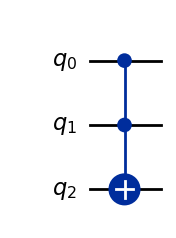

In [15]:
toffoli_layout = [122, 124, 126]

toffoli = QuantumCircuit(3)
toffoli.ccx(0, 1, 2)
toffoli.draw("mpl")

In [ ]:
# To know the original circuit depth

# transpile the circuit
## your code goes here ##

# original circuit depth
## your code goes here ##
isa_toffoli_depth = 

print(f"Transpiled circuit depth: ", isa_toffoli_depth)
#isa_qc.draw("mpl", scale=0.6, idle_wires=False, style="iqp", fold=-1)

In [ ]:
# To know the depth using circuit cutting

## your code goes here ##

# Find the indices of the distant gates
## your code goes here ##
gates_connecting_to_cut =

# Decompose distant CNOTs into TwoQubitQPDGate instances
## your code goes here ##


#qpd_circuit.draw("mpl", style="iqp", scale=0.6)

In [ ]:
# set the observables
observable = SparsePauliOp(["ZZZ"])

# Generate the subexperiments and sampling coefficients
# Add your code here

# Transpile the circuit
# Add your code here

# Depth using circuit cutting
# Add your code here
isa_qpd_toffoli_depth =

print(f"Transpiled circuit depth: ", isa_toffoli_depth)
print(f"QPD subexperiment depth after transpile: ", isa_qpd_toffoli_depth)
#print(f"Number of sub-experiments:", len(subexperiments))
#isa_qpd_circuit.draw("mpl", scale=0.6, style="iqp", idle_wires=False, fold=-1)

In [ ]:
# mean of the depth of all subexperiments
# Add your code here

isa_qpd_toffoli_depth_mean =

print(isa_qpd_toffoli_depth_mean)

In [ ]:
# Submit your answer using following code
from qc_grader.challenges.iqc_2024 import grade_lab5_ex1

grade_lab5_ex1(gates_connecting_to_cut, isa_toffoli_depth, isa_qpd_toffoli_depth_mean) 
# Expected result type: dict, str, str

In [ ]:
# Grader Test Cell
from lab5 import grade_lab5_ex1

grade_lab5_ex1(gates_connecting_to_cut, isa_toffoli_depth, isa_qpd_toffoli_depth_mean)
# Expected result type: dict, str, str

**Open question** to those who finished the exercise and have extra power: What would be the depth if more than two connections are cut?

# Part 2: Custom Fake Backends

### Current status of quantum hardware:

IBM continues to push the boundaries of quantum hardware through its IBM Quantum program. Leveraging superconducting qubits, IBM has developed various topologies for their quantum processors, including transmon qubits and coupled qubit architectures, enabling the execution of more complex quantum operations. With innovations like the Open Pulse Architecture, users gain direct access to qubit control signals, enhancing flexibility in circuit design. IBM has made strides in increasing the size of quantum circuits that can be executed, with processors boasting up to 127 qubits, although not all qubits may be fully connected.

Now if we want to learn more about the potential of future hardware, Qiskit 1.0 offers a way that you can build fake backends that has futuristic topologies.



### How can we utlize fake backend?

Fake backends can be used to either create a noise model for existing machines like we did in Lab 2 or to try and imagine how future quantum computers will look like!

In this lab we will focus on creating future quantum computing topologies using the BackendV2 module in Qiskit 1.0.


Before we start building a fake backend, we need to point out that backends have different topologies and we need to design out circuit according to that topology of the backend.

Currently, the transpiler maps the circuits we send it to the existing hardware we are targeting. However, since we are creating our own topologies, we will need to also design our circuits accordingly.

To walk through our example, assume we are trying to build a large GHZ state circuit (> 200 qubits). We know that we can't simulate it or run on any of the current devices.

However we can use Qiskit 1.0 to design a future device topology and then execute the circuit on it.

Qiskit 1.0 offers several types of topologies (connection between the qubits), some of these topologies are:
- Heavy Hex
- Grid Graph
- Mesh Graph
- Star Graph

To learn more about the different possible topologies, check the [RustWorkX](https://www.rustworkx.org/stable/0.12/api.html#generators) API documentation. 

In this exercise we will use two of these topologies, the multichip and the grid graph topologies.


### Multichip Backend

A multichip system distributes the qubits over several chips all containing the same number of qubits.

To create a multichip backend **directed_heavy_hex_graph**, we need to define a few things:

- distance (int): The heavy hex code distance to use for each chips coupling map. This number **must** be odd. The distance relates to the number of qubits by:


$
n = \frac{5d^2 - 2d - 1}{2} 
$

  
where **n** is the number of qubits and **d** is the **distance**

- number_of_chips (int): The number of chips to have in the multichip backend each chip will be a heavy hex graph of **distance** code distance.

The distance is used to generate the topology of the quantum hardware, specifically in constructing the heavy hex graph. Here, the distance is related to the heavy hex code distance, which is a measure of the distance between qubits in a specific arrangement.

The heavy hex code distance is typically an odd number. This is because odd distances allow for better error correction properties in certain error-correcting codes, such as the surface code. Odd distances can facilitate the creation of logical qubits with fewer physical qubits, as they allow for the placement of syndrome measurements (checks for errors) in a more efficient way.

We also need to define the basis gates of that fake backend. The choice of those basis gates depends on the circuit we will try to execute on this fake backend.
To add a gate we need to:

- Choose the Gate: Decide which gate you want to add to the backend. Qiskit provides a variety of built-in gates such as Pauli gates, single-qubit rotation gates, and multi-qubit gates like the controlled-NOT gate (CNOT). You can also define custom gates if needed.
- 
Define Instruction Properties: Determine the properties of the gate you want to add, such as error rates, durations, and any other relevant parameters. These properties will **specify how accurately and quickly the gate can be executed on the quantum hardware**.
-  
Create Instruction Properties: Instantiate an InstructionProperties object to encapsulate the properties of the gate. This object typically includes attributes like error, duration, and any other relevant parameters specific to the gate.
-  
Add to Target: Add the gate and its corresponding instruction properties to the Target object associated with the backend. The Target object represents the capabilities and characteristics of the quantum hardware.
- 
Connectivity Consideration (for Multi-Qubit Gates): If you're adding a multi-qubit gate like a CNOT gate, ensure that you specify instruction properties for each pair of qubits that are connected in the hardware topology. This is crucial for accurately simulating the behavior of the quantum circuit on the backend.

The instruction properties, namely, the error and duration are often set based on the average of the NISQ backends.

For this exercise, we have set vlaues for those attributes for grading purposes, but, you can try to change those values and see how it efects your results and the accuracy of the execution.

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 
Step 1: Build a blue print for a 3 chip backend system using the outline code below

Step 2: Generate a 3 x 133 qubits (399 qubits total) using the blueprint you created

Step 3: Use the ```Transpile``` function to compile the GHZ circuit onto the backend you just created!
</div>



<div class="alert alert-block alert-info">

To build the backend blue print, you need to add the basis gates! **RZ, X and SX**.

For example, to add the SX gate, you need to add the following lines of code:


- import the SXGate from the qiskit ciruit library
- sx_props = {}
- sx_props[qarg] = InstructionProperties(error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7))
- self._target.add_instruction(SXGate(), sx_props)

The gate properties is the shape of its pulse and the error we want it to contain **Don't change the numbers in the instruction properties!!**

**You will add 3 lines of code for each gate after importing all of them from the [Qiskit circuit library](https://docs.quantum.ibm.com/api/qiskit/circuit_library#standard-gates)**


In [ ]:
#Import the gates 
#Add your code here
#from qiskit.circuit.library import


class FakeLOCCBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self, distance=3, number_of_chips=3):
        super().__init__(name='Fake LOCC backend')
        graph = rx.generators.directed_heavy_hex_graph(distance, bidirectional=False)
        num_qubits = len(graph) * number_of_chips
        rng = np.random.default_rng(seed=12345678942)
        
        # Define your gates props here
        # Add your code here


        
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake multi-chip backend", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            
            # Add your gates here, assign the props
            # Add your code here


            
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None
            
        #Append your gates to the backend here using self._target.add_instruction
        # Add your code here

        
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)

        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for i in range(number_of_chips):
            for root_edge in graph.edge_list():
                offset = i * len(graph)
                edge = (root_edge[0] + offset, root_edge[1] + offset)
                cz_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3), duration=rng.uniform(1e-8, 9e-7)
                )
        self._target.add_instruction(CZGate(), cz_props)
        cx_props = {}

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Can't implement")

<div class="alert alert-block alert-success">

To create a fake backend, you need two numbers, the distance and number of chips! (FakeLOCCBackend(distance, number of chips))

$
n = \frac{5d^2 - 2d - 1}{2} 
$

**hint** use the number of qubits to obtain the distance *d*.

In [ ]:
# Generate a backend with 3x 133 qubit (399 qubits total):
backend = # add your code here


Now that we have the blueprint for the backend, we can use it to build a custom 3 chip system containing 133 qubits.
We can use the equation above to get the distance.

In [ ]:
plot_gate_map(backend)

Because we have a 3-chip system, we need the GHZ to be dividable into 3 sections each containing 133 or less qubits.

To test our fake backend, let us build a 3 x 133 GHZ state.

In [ ]:
# Build (3 x 133) qubit ghz states and then perfomrm a measurement (measureall) operation 
ghz = QuantumCircuit(399)




To run our circuits on the fake backend, we will use the ```transpile()``` function.


In Lab 2, you learned a lot about the different stages of the transpilation process using the ```generate_preset_pass_manager```. To use the pass manager we need to define the stages.

However, for this lab, we want to focus more on the topologies of the backends, because of that, we will use the ```transpile``` function. If we want we can set the parameters we want, but, if we don't the function will use the default settings for the backend.

In this example, the only parameter we will set is the **seed_transpile** to keep the answers consistent.

<div id='problem'></div>
<div class="alert alert-block alert-info">
    
**Set the seed_transpiler parameter to 40000**

In [ ]:
# Compile the split ghz circuit
t_ghz_qc = # add your code here

Now, we can visualize the layout on the backend.

In [ ]:
plot_circuit_layout(t_ghz_qc, backend)

In [ ]:
# Grader cell
# Submit your transpiled GHZ circuit on the back end you created
from lab5 import grade_lab5_ex2

grade_lab5_ex2(t_ghz_qc)
# Make sure you pass the grader a QuantumCircuit object.

In this example, we needed to create a circuit that can be easily divided by the transpiler into 3 sections.

What happens if we didn't do that? what happens if we built the circuit as a one big set of gates? Like the Bernstein Vazirani algorithm?


<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 3:</b> 

Step 1: Write a code implementing Bernstein-Vazirani for a 399 qubits and then compile it to the backend!
 
Implement the algorithmic steps above for a circuit containing 399 qubits (n= 399).

Step 2: Write a code implementing Bernstein-Vazirani for a 399 qubits and then compile it to the backend!
    
Implement the algorithmic steps above for a circuit containing 399 qubits (n= 399) then perform measurment to the all qubits except the last to reveal hidden string!!

Step 3: Execute the Bernstein-Vazirani circuit from above on the fully connected backend using the ```transpile``` function


</div>

## The Bernstein-Vazirani algorithm
The Bernstein-Vazirani algorithm is a quantum algorithm that solves the problem of finding a hidden integer s given an oracle function 

$
f(x) = a \cdot x
$

where a and x are n-bit while f(x)has only one bit. This problem was first introduced by Ethan Bernstein and Umesh Vazirani in 1993 as a counterpart to Deutsch's problem.

Classically, if you want to determine the hidden string, you would need to query the oracle multiple times to get enough information about the answer. However, the Bernstein-Vazirani algorithm, being a quantum algorithm, solves this problem in a single query.

To implment the algorithm, we follow these steps:


1. **Initialization**: The quantum circui with n qubits and apply X to the last one.

2. **Hadamard Gates**: Hadamard gates are applied to all qubits, creating an equal superposition of all possible input states.

3. **Oracle**: which is implemented by a controlled-NOT (CNOT) gate co the first n-1 as control and the last qubit as target.

4. **Hadamard Gates (Again)**: Apply H gate to all qubits.

5. **Measurement**: Finally, measuring all qubits except the last one revealing the answer.


In [ ]:
#Implement the Bernstein-Vazirani circuit and the perform a measureall operatoion
num_qubits = 399
bv = QuantumCircuit(num_qubits, num_qubits - 1)
#add your code here

If we try to transpile this circuit on our 3 chip system, we get an error.

In [ ]:
from qiskit.transpiler import TranspilerError
from qiskit import transpile
try:
    transpile(bv, backend)
except TranspilerError as e:
    print(e)

Here we got an error because the transplier can't divide the circuit by itself and the entire circuit was 399 qubits which is larger than the size of a single chip.

We can avoid that by using a different circuit topology


## A fully connected backend
---

In this case we use a different topology **grid graph** that has 20 rows and 20 columns (that is 400 qubits)

For this backend, we will use the **directed_grid_graph**

This will generate a fully connected 400 qubits backend that we can use to execute the GHZ circuit without the need to divide it!

The **directed_grid_graph** is inspired by the topology of Toric codes.

The toric code is a two-dimensional topological quantum error-correcting code proposed by Alexei Kitaev in 1997. It is defined on a toroidal lattice, which wraps around itself in both horizontal and vertical directions, resembling the surface of a doughnut. The toric code encodes logical qubits using non-local, topological properties of the lattice.


st: Each qubit in the toric code is associated with a vertex or a plaquette of the lattice. The logical qubits are encoded using non-trivial topological configurations of qubits on the lattice.

con: Errors in the toric code, such as single-qubit and multi-qubit errors, are corrected using non-local measurements of certain observables associated with plaquettes and vertices of the lattice. These measurements allow the detection and correction of errors without directly measuring the state of individual quber run method.


To build a fake using Qiskit 1.0, weou would need to define the following components:

1- Graph Generation: Define a two-dimensional lattice resembling a torus, such as a square lattice with periodic boundary conditions or a hexagonal lattice.

2- Instruction Properties: Define properties for single-qubit gates (e.g., XGate, SXGate, RZGate), measurement (Measure), reset (Reset), delay (Delay), and two-qubit gate (CZGate). These properties include error rates and durations, simulating the behavior of gates on the quantum hardware.

3- Adding Gates to Target: Add the gates and their corresponding instruction properties to the Target object associated with the backend. Ensure that connectivity considerations are taken into account for the two-qubit gate (CZGate) to reflect the toroidal lattice topology.

4- Backend Properties: Define properties such as the name of the backend, the maximum number of circuits that can be executed, default options for circuit execution, and a placeholder run method.

In [ ]:
class FakeTorusBackend(BackendV2):

    def __init__(self):
        """Instantiate a new backend that is inspired by a toric code"""
        super().__init__(name='Fake LOCC backend')
        n =   #ADD the value of n
        graph = rx.generators.directed_grid_graph(n, n)
        for column in range(n):
            graph.add_edge(column, (n-1)*n + column, None)
        for row in range(n):
            graph.add_edge(row * n, row * n + (n-1), None)
        num_qubits = len(graph)
        rng = np.random.default_rng(seed=12345678942)
        
        # Define your gates props here
        # Add your code here

        
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake Kookaburra", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)

            # Add your gates here
            # Add your code here

            
            
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None

        #Append your gates to the backend here using self._target.add_instruction
        #Add your code here
        
        
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for edge in graph.edge_list():
            offset = i * len(graph)
            cz_props[edge] = InstructionProperties(
                error=rng.uniform(7e-4, 5e-3), duration=rng.uniform(1e-8, 9e-7)
            )
        self._target.add_instruction(CZGate(), cz_props)

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Can't implement")

In [ ]:
# Create the backend
backend_connected = # add your code here

We can now create the backend and draw it

In [ ]:
plot_gate_map(backend_connected)

<div id='problem'></div>
<div class="alert alert-block alert-info">   


**Set the seed_transpiler parameter to 40000**

In [ ]:
# Use the transpile function
t_bv_qc = # add your code here

Now we can plot the backend and see which qubits are used.

In [ ]:
plot_circuit_layout(t_bv_qc, backend_connected)

This gives you an idea on what you can do with the fake backend feature in Qiskit 1.0. So go ahead and imagine the future of quantum computing hardware!


In [ ]:
# Grader cell
#Please submit the transpiled Bernstein-Vazirani circuit on the fully connected backend
from lab5 import grade_lab5_ex3

grade_lab5_ex3(t_bv_qc)
#Make sure your submit a QuantumCiruit object to the grader

# 3. Code Assistant

# Additional information

**Created by:** Kifumi Numata, Sara Metwalli, Siddharth Golecha

**Advised by:** Junye Huang

**Version:** 1.0

# Qiskit packages versions

In [1]:
import qiskit
import qiskit_ibm_runtime
import circuit_knitting

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
#print(f'Circuit Knitting Toolbox: {circuit_knitting.__version__}')

/Users/kifumi/local/qiskit_env/qiskit_102_0503/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Qiskit: 1.0.2
Qiskit IBM Runtime: 0.23.0


> Print main qiskit packages versions. Print only packages that are used in the notebook. Rememeber to add additional packages that are used in the notebook like `prototype-zne` or `circuit-knitting-toolbox`.